<a href="https://colab.research.google.com/github/aanilkumarreddy/DataDiggers/blob/main/dataOptimizationFB_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd #Data manipulation and analysis
import numpy as np #Numerical computing
import matplotlib.pyplot as plt #Data Visualzation
import seaborn as sns #Data Visualzation
import time #Various time-related functions

In [ ]:
!pip install --upgrade pandas-datareader
!pip install --upgrade pandas

     |████████████████████████████████| 109 kB 4.2 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [ ]:
#Settings for appropriate display  

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [ ]:
#Ignoring all warning ⚠ messages thrown

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas_datareader as pdr #Remote data access for pandas
from datetime import date

df = pdr.DataReader('FB', data_source='yahoo', start='2018-01-01', end = "2021-12-31")
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-02,181.580002,177.550003,177.679993,181.419998,18151900,181.419998
2018-01-03,184.779999,181.330002,181.880005,184.669998,16886600,184.669998
2018-01-04,186.210007,184.100006,184.899994,184.330002,13880900,184.330002
2018-01-05,186.899994,184.929993,185.589996,186.850006,13574500,186.850006
2018-01-08,188.899994,186.330002,187.199997,188.279999,17994700,188.279999


In [ ]:
df = df["Close"]
df = pd.DataFrame(df)
df.head()

,Close
Date,
2018-01-02,181.419998
2018-01-03,184.669998
2018-01-04,184.330002
2018-01-05,186.850006
2018-01-08,188.279999


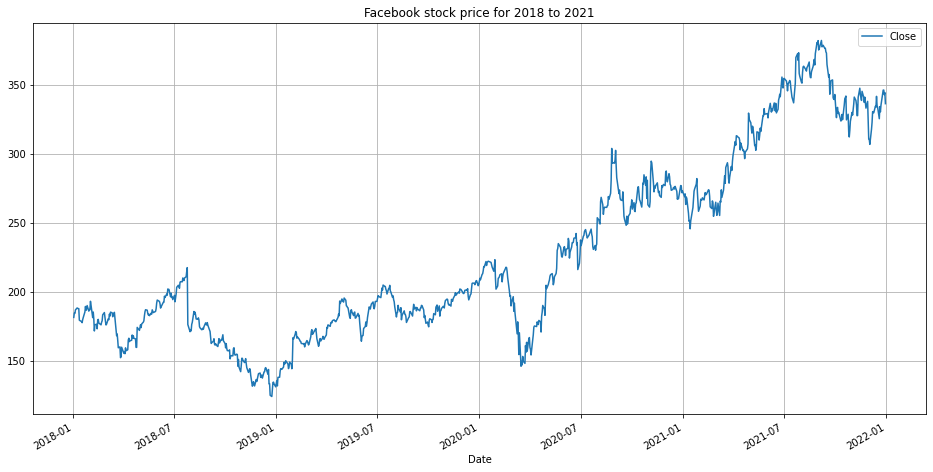

In [ ]:
df.plot(figsize=(16,8), title = "Facebook stock price for 2018 to 2021", grid = True)

In [ ]:
%matplotlib inline
#from matplotlib.pylab import rcParams
#rcParams['figure.figsize'] = 15, 6

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout

import math
from math import sqrt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
data = df

In [ ]:
train_data = data[2:300] 
test_data = data[300:] 
train = train_data.values

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train) 

timesteps = 7
X_train = []
y_train = []
for i in range(timesteps, train.shape[0]):
    X_train.append(train_scaled[i-timesteps:i, 0]) # we take 30 previous prices
    y_train.append(train_scaled[i, 0]) # and 60-th price as y value
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
from numpy.random import seed
seed(2019)

model = Sequential()
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Adding the first LSTM layer 
# Here return_sequences=True means whether to return the last output in the output sequence, or the full sequence.
# it basically tells us that there is another(or more) LSTM layer ahead in the network.
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))

# Dropout regularisation for tackling overfitting
model.add(Dropout(0.20))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.25))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.25))

# Adding the output layer
model.add(Dense(units = 1))

In [ ]:
# Compiling the RNN
# RMSprop is a recommended optimizer as per keras documentation
# check out https://keras.io/optimizers/ for more details
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
%time model.fit(X_train, y_train, epochs = 40, batch_size = 32)

Epoch 1/40
10/10 [==============================] - 10s 19ms/step - loss: 0.1904
Epoch 2/40
10/10 [==============================] - 0s 20ms/step - loss: 0.0420
Epoch 3/40
10/10 [==============================] - 0s 21ms/step - loss: 0.0361
Epoch 4/40
10/10 [==============================] - 0s 20ms/step - loss: 0.0261
Epoch 5/40
10/10 [==============================] - 0s 23ms/step - loss: 0.0217
Epoch 6/40
10/10 [==============================] - 0s 19ms/step - loss: 0.0157
Epoch 7/40
10/10 [==============================] - 0s 20ms/step - loss: 0.0119
Epoch 8/40
10/10 [==============================] - 0s 21ms/step - loss: 0.0123
Epoch 9/40
10/10 [==============================] - 0s 20ms/step - loss: 0.0116
Epoch 10/40
10/10 [==============================] - 0s 19ms/step - loss: 0.0110
Epoch 11/40
10/10 [==============================] - 0s 19ms/step - loss: 0.0119
Epoch 12/40
10/10 [==============================] - 0s 20ms/step - loss: 0.0137
Epoch 13/40
10/10 [=================

In [ ]:
# this will be used later while comparing and visualization

real_stock_price = test_data.iloc[:,0:1].values # taking open price

In [ ]:
# combine original train and test data vertically
# as previous Open Prices are not present in test dataset
# e.g. for predicting Open price for first date in test data, we will need stock open prices on timesteps previous dates  
combine = pd.concat((train_data['Close'], test_data['Close']), axis = 0)

# our test inputs also contains stock open Prices of last timesteps dates (as described above)
test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

In [ ]:
# same steps as we followed while processing training data
X_test = []
for i in range(timesteps, test_data.shape[0]+timesteps):
    X_test.append(test_inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)

# inverse_transform because prediction is done on scaled inputs
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

In [ ]:
import math
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error

print('Mean Square Error (MSE): '+str(mean_squared_error(real_stock_price, predicted_stock_price)))
print('Mean Absolute Error(MAE): '+str(mean_absolute_error(real_stock_price, predicted_stock_price)))
print('Root Mean Square Error (RMSE): '+str(math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))))

Mean Square Error (MSE): 2093.843322562242
Mean Absolute Error(MAE): 33.804694094900356
Root Mean Square Error (RMSE): 45.75853278419493


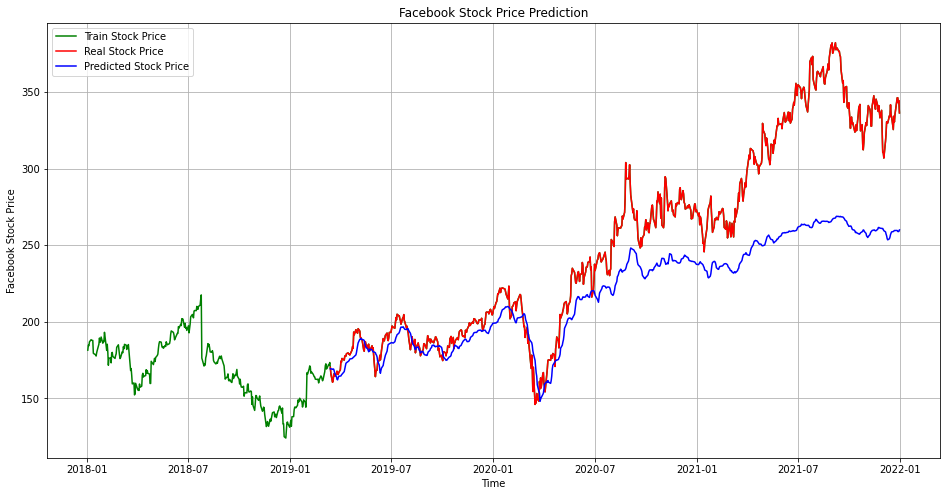

In [ ]:
#Visualize entire data

plt.figure(figsize=(16,8))
plt.plot(data.index, data['Close'], color='green', label = 'Train Stock Price')
plt.plot(test_data.index, real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Facebook Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Facebook Stock Price')
plt.legend()
plt.grid(True)
plt.show()

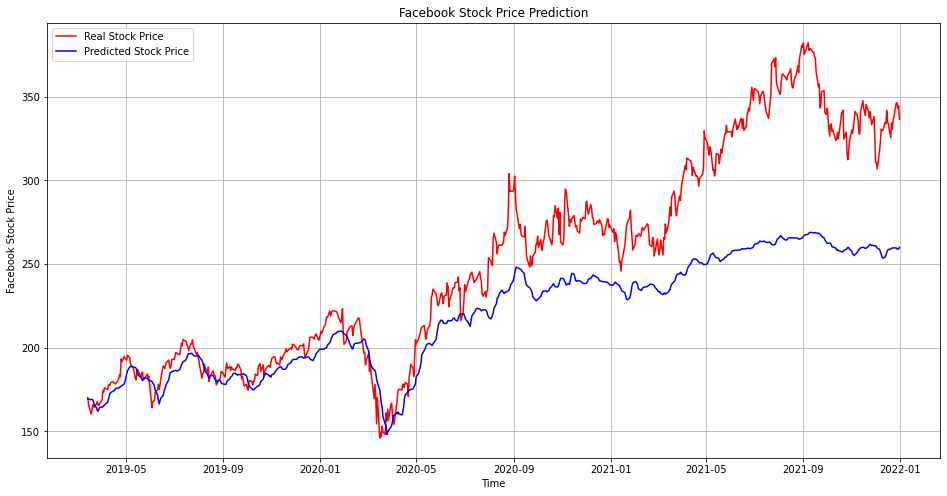

In [ ]:
#Visualize the test data

plt.figure(figsize=(16,8))
plt.plot(test_data.index, real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Facebook Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Facebook Stock Price')
plt.legend()
plt.grid(True)
plt.show()